In [48]:
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image
from batch_norm_note import BatchNormLayer
import seaborn as sns

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import os

# The model of Real NVP¶

Base distribution : $Z$.<br>
Target Distribution: $X$.<br>
Flow $f = f_n \circ f_{n-1} \circ f_{n-2}\cdots f_1$ <br>
$Z = f(X)$

# Implement the coupling layer

In [49]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask

    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x

Suppose $X$ and $Z$ all have D dimensions. I mask d
For the forward function above, we use the formula below:<br>
$z_{1:d} = x_{1:d}$ <br>
$z_{d+1: D} = x_{d+1:D}\odot exp(s(x_{1:d})) + t(x_{1:d})$<br>
<br>

Get the determinant contributed by this transformation: $exp(s(x_{1:d}))$

Backward function is using the formula below:<br>
$x_{1:d} = z_{1:d}$ <br>
$x_{d+1:D} = (z_{d+1:D} - t(z_{1:d}))\odot exp(-s(z_{1:d}))$ <br>


In [50]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(BatchNormLayer(input_dim))
        
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
            self.modules.append(BatchNormLayer(input_dim))
            
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.modules.append(BatchNormLayer(input_dim))
        
        self.module_list = nn.ModuleList(self.modules)
        
    def forward(self, x):
        #ldj_sum = 0 # sum of log determinant of jacobian
        ldj_sum = torch.zeros(x.shape[0])
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        #ldj_sum = 0 # sum of log determinant of jacobian
        ldj_sum = torch.zeros(z.shape[0])
        for module in reversed(self.module_list):
            z, ldj = module.backward(z)
            ldj_sum += ldj
        return z, ldj_sum

Sum of the log determinant of jacobian for each layer:
$\sum_j s_j(x_{1:d})$.<br>

What we should note here is that the compnent which is identical in 1 transformation will be modified in the next transformation

In [51]:
'''
Training Data Creation
'''

'''
Generating twelve independent normal distribution
'''
a = torch.zeros(12)
b = torch.tensor([1,2,4,1,2,4,1,2,2,2,2,2])
s_dist = distributions.Normal(a, b)
sample_normal = s_dist.sample(torch.Size([60000]))


'''
Generate the sample of X
'''
sample_X = sample_normal[:,0].pow(2)
for i in range(1,8):
    sample_X = torch.column_stack((sample_X,sample_normal[:,i].pow(2)))

sample_X = torch.column_stack((sample_X, sample_normal[:,8].pow(2) 
                               + sample_normal[:,9].pow(2)))
sample_X = torch.column_stack((sample_X, sample_normal[:,10].pow(2) 
                               + sample_normal[:,11].pow(2)))


'''
Load Data
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
train_loader = torch.utils.data.DataLoader(sample_X, batch_size=500, shuffle=True, **kwargs)

In [52]:
'''
Test data
This data is used to test the accuracy of our model
'''

test_normal = s_dist.sample(torch.Size([1000]))

test_X = test_normal[:,0].pow(2)
for i in range(1,8):
    test_X = torch.column_stack((test_X, test_normal[:,i].pow(2)))

test_X = torch.column_stack((test_X, test_normal[:,8].pow(2) 
                               + test_normal[:,9].pow(2)))
test_X = torch.column_stack((test_X, test_normal[:,10].pow(2) 
                               + test_normal[:,11].pow(2)))

Each component of data is independent from other components:
$[X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_{10}]$<br>
$X_1, X_4, X_7 \sim Gamma(\frac{1}{2}, \frac{1}{2}) $ <br>
$X_2, X_5, X_8 \sim Gamma(\frac{1}{2}, \frac{1}{8})$<br>
$X_3, X_6 \sim Gamma(\frac{1}{2}, \frac{1}{32})$ <br>
$X_9, X_{10} \sim Gamma(1, \frac{1}{8})$ <br>


In [53]:
BATCH_SIZE = 500
LOG_INTERVAL = 50
EPOCHS = 15
INPUT_DIM = 10
OUTPUT_DIM = 10
HIDDEN_DIM = 256
N_COUPLE_LAYERS = 4

In [54]:
mask = torch.from_numpy(np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]).astype(np.float32))
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
prior_z = distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

# Training the Data

In [55]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        z, log_det_j_sum = model(data)
        loss = -(prior_z.log_prob(z)+log_det_j_sum).mean()
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                cur_loss/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))

In [56]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.065833
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.013500
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.012697
====> Epoch: 1 Average loss: 0.0166
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.012101
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.011315
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.011728
====> Epoch: 2 Average loss: 0.0118
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.011621
Train Epoch: 3 [25000/60000 (42%)]	Loss: 0.011790
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.010959
====> Epoch: 3 Average loss: 0.0113
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010748
Train Epoch: 4 [25000/60000 (42%)]	Loss: 0.010696
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.011307
====> Epoch: 4 Average loss: 0.0110
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010165
Train Epoch: 5 [25000/60000 (42%)]	Loss: 0.010120
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.010912
====> Epoch: 5 Average loss: 0.0107
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.011093
Train Epoch: 6 [25000/60000 (42%)]	Loss: 0.010316


# Test my results

Compare the accurate log probability of X with my estimation

In [57]:
Gamma_147 = torch.distributions.Gamma(1/2, 1/2, validate_args=None)
Gamma_258 = torch.distributions.Gamma(1/2, 1/8, validate_args=None)
Gamma_36 = torch.distributions.Gamma(1/2, 1/32, validate_args=None)
Gamma_910 = torch.distributions.Gamma(1, 1/8, validate_args=None)

Use the property of independent of random variables

In [58]:
#Accurate log probability:
Log_prob_correct = ( Gamma_147.log_prob(test_X[:,0]) + Gamma_147.log_prob(test_X[:,3]) + Gamma_147.log_prob(test_X[:,6])
                   + Gamma_258.log_prob(test_X[:, 1]) + Gamma_258.log_prob(test_X[:, 4]) + Gamma_258.log_prob(test_X[:, 7])
                    + Gamma_36.log_prob(test_X[:,2]) + Gamma_36.log_prob(test_X[:,5])
                     + Gamma_910.log_prob(test_X[:, 8]) +  Gamma_910.log_prob(test_X[:, 9]) )

prob_1 = torch.exp(Log_prob_correct)


In [59]:
#Log probability of my estimation
model.eval()
with torch.no_grad():
         z_val, Log_Det = model.forward(test_X)
         Log_prob_est = prior_z.log_prob(z_val) + Log_Det
        
prob_2 = torch.exp(Log_prob_est)

setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation


In [62]:
#Calculating the KL divergence value
KL_divergence =(prob_2 * (Log_prob_est - Log_prob_correct)).sum()
print(KL_divergence)

tensor(12291.9609)


In [63]:
#drawing the graph
base_class = distributions.Normal(torch.zeros(10), torch.ones(10))
draw_sample = base_class.sample(torch.Size([5000]))


In [64]:
#Generated data from our model
model.eval()
with torch.no_grad():
      Generated_data, Log_det_I = model.forward(draw_sample)

In [67]:

X_3 = Generated_data[:,2].numpy()

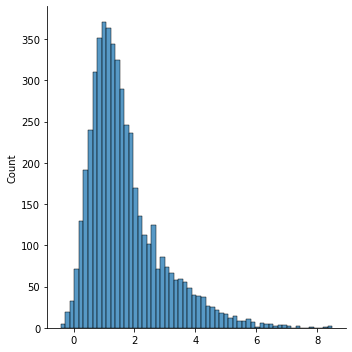

In [68]:
sns.displot(X_3)

In [38]:
sample_258 = Gamma_910.sample(torch.Size([3000]))

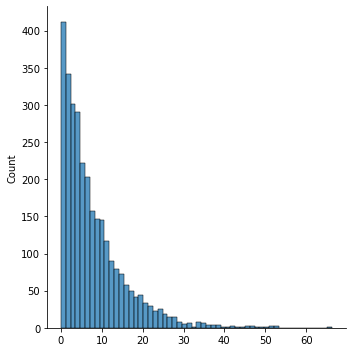

In [39]:
sns.displot(sample_258)